# Outlab 6
- **Author: Kirill Shumilov**

**For all analysis done here SOR relaxation factor is 1.8**

## Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as np

import json

In [2]:
with open('timing_info.json') as f:
    data = json.load(f)
    df_all = pd.DataFrame.from_records(data)

df_all['time'] //= 1000
df_all['algo'] = pd.Categorical(df_all['algo'])


O = lambda x, n, C, S: C * (x ** n) + S

## Relative Error, $\delta^\mu$

In [3]:
with pd.option_context('display.precision', 5, "display.expand_frame_repr", False, 'display.float_format', lambda f: f'{f: 12.6e}'):
    print(pd.pivot(df_all[df_all.algo != 'LUP'], columns='n', index='algo', values='max_deviation'))

n             32            64            128           256           512           1024
algo                                                                                    
PJ    3.548085e-05  2.991004e-05  2.589729e-05  2.282751e-05  2.042514e-05  1.850604e-05
GS    1.754772e-05  1.508183e-05  1.299976e-05  1.138514e-05  1.020487e-05  9.258200e-06
SOR   2.492362e-06  4.548747e-07  2.064188e-06  2.134746e-06  1.951659e-06  1.808526e-06


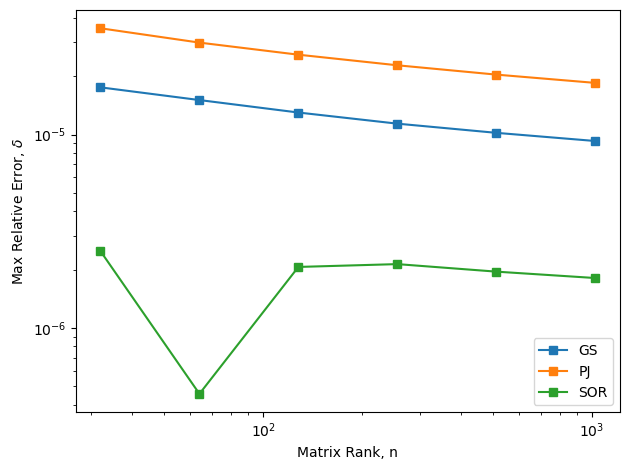

In [4]:
fig, ax = plt.subplots(1, 1, layout='tight', sharex=True)
for i, (algo, dfa) in enumerate(df_all[df_all.algo != 'LUP'].groupby('algo', observed=True)):
    ax.loglog('n', 'max_deviation', 's-', data=dfa, label=algo)
ax.legend()
ax.set_xlabel('Matrix Rank, n')
ax.set_ylabel('Max Relative Error, $\delta$')
plt.show()

It can be observed that the error is below tolerance error of 1e-4. The error decreases with increasing matrix rank. It is smallest for SOR and largest for PJ. The kink in SOR plot can be explained by the fact that the error is dependent on relaxation factor, which itself depends on structure of the matrix, and potentially was not optimal for all $n$.

## Execution Time

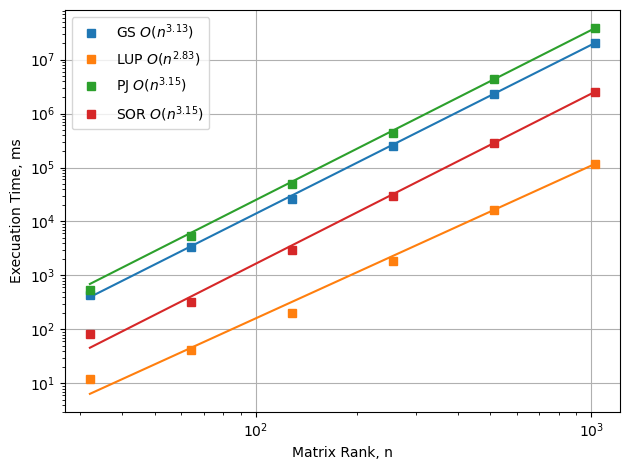

In [5]:
fig, ax = plt.subplots(1, 1, layout='tight', sharex=True)
for i, (algo, dfa) in enumerate(df_all.groupby('algo', observed=True)):
    popt, pcov = curve_fit(O, dfa['n'], dfa['time'], p0=(2, 1e-2, 0), bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))
    ax.loglog('n', 'time', 's', data=dfa, label=' '.join([f'{algo}', r'$O(n^{%3.2f})$' % (popt[0])]), color=f'C{i}')
    ax.loglog(dfa['n'], O(dfa['n'], *popt), '-', color=f'C{i}')

ax.legend()
ax.set_xlabel('Matrix Rank, n')
ax.set_ylabel('Execuation Time, ms')
ax.grid(True)

plt.show()

We can see that execuation time scales roughly as $O(n^3)$, give or take for all methods, as is expected, given that all methods rely on matrix multiplies. The approximately the same for all iterative methods. The primary difference comes from the constant in front of the scaling. It is smallest for LUP and largest for PJ.

## Number of Iterations

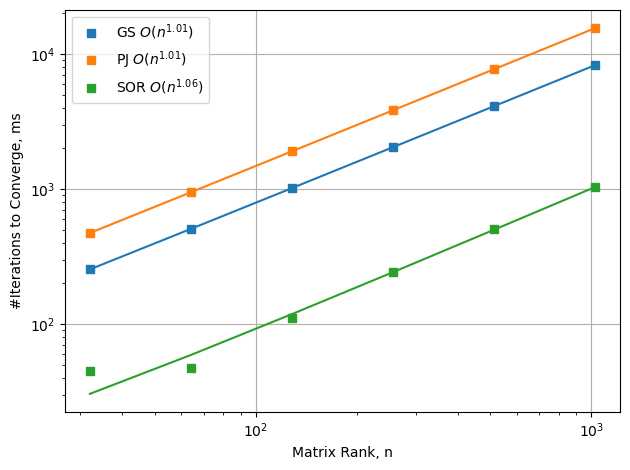

In [6]:
fig, ax = plt.subplots(1, 1, layout='tight', sharex=True)
for i, (algo, dfa) in enumerate(df_all[df_all.algo != 'LUP'].groupby('algo', observed=True)):
    popt, pcov = curve_fit(O, dfa['n'], dfa['iterations'], p0=(2, 1e-2, 0), bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))
    ax.loglog('n', 'iterations', 's', data=dfa, label=' '.join([f'{algo}', r'$O(n^{%3.2f})$' % (popt[0])]), color=f'C{i}')
    ax.loglog(dfa['n'], O(dfa['n'], *popt), '-', color=f'C{i}')

ax.legend()
ax.set_xlabel('Matrix Rank, n')
ax.set_ylabel('#Iterations to Converge, ms')
ax.grid(True)

plt.show()

For all iterative methods, the number of iterations to converges is rougly proportional to matrix rank, with constant factor determining overall shape of the scaling. SOR has requires an order of magnitude fewer iterations to converge.